## Importing the libraries

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#inline matplotlib

## Importing the data 

In [ ]:
raw_data_directory = "..\\data\\raw\\"
!dir $raw_data_directory

In [2]:
# Importing the data
energy = pd.read_csv(raw_data_directory+ "consumption_train.csv", index_col=0)
meta = pd.read_csv(raw_data_directory + "meta.csv")

## Extracting the dimensions of each dataset

In [3]:
# Printing the column names and dimension of both data sets
print("The columns are =>", energy.columns)
print("The timeseries dataset dimensions are =>", energy.shape)
print("The metadata dataset dimensions are =>", meta.shape)

The columns are => Index(['series_id', 'timestamp', 'consumption', 'temperature'], dtype='object')
The timeseries dataset dimensions are => (509376, 4)
The metadata dataset dimensions are => (1383, 10)


In [4]:
# Preview of the datasets
print(energy.info())
print()
print(meta.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509376 entries, 0 to 509375
Data columns (total 4 columns):
series_id      509376 non-null int64
timestamp      509376 non-null object
consumption    509376 non-null float64
temperature    280687 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 19.4+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 10 columns):
series_id               1383 non-null int64
surface                 1383 non-null object
base_temperature        1383 non-null object
monday_is_day_off       1383 non-null bool
tuesday_is_day_off      1383 non-null bool
wednesday_is_day_off    1383 non-null bool
thursday_is_day_off     1383 non-null bool
friday_is_day_off       1383 non-null bool
saturday_is_day_off     1383 non-null bool
sunday_is_day_off       1383 non-null bool
dtypes: bool(7), int64(1), object(2)
memory usage: 41.9+ KB
None


## Counting the missing values

In [5]:
# Counting missing values
print(energy.isnull().sum())
print()
print(meta.isnull().sum())

series_id           0
timestamp           0
consumption         0
temperature    228689
dtype: int64

series_id               0
surface                 0
base_temperature        0
monday_is_day_off       0
tuesday_is_day_off      0
wednesday_is_day_off    0
thursday_is_day_off     0
friday_is_day_off       0
saturday_is_day_off     0
sunday_is_day_off       0
dtype: int64


## Exploratory Data Analysis
### Correlation between energy consumption and temperature

,series_id,consumption,temperature
series_id,1.000000,0.013681,-0.116543
consumption,0.013681,1.000000,0.099456
temperature,-0.116543,0.099456,1.000000


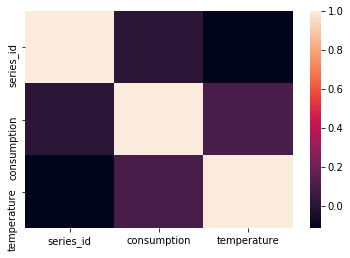

In [6]:
# Getting correlational heatmap, focussing on the potential relationship between consumption and temperature
corr = energy.corr()
sns.heatmap(corr, 
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
corr

In [7]:
meta.head(5)

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
0,100003,x-large,low,False,False,False,False,False,True,True
1,100004,x-large,low,False,False,False,False,False,True,True
2,100006,x-small,low,False,False,False,False,False,True,True
3,100008,x-small,low,False,False,False,False,False,True,True
4,100010,x-small,low,False,False,False,False,False,True,True


In [8]:
meta["weekly"] = meta.monday_is_day_off.map(str) + meta.tuesday_is_day_off.map(str) + meta.wednesday_is_day_off.map(str) + meta.thursday_is_day_off.map(str) + meta.friday_is_day_off.map(str) + meta.saturday_is_day_off.map(str) + meta.sunday_is_day_off.map(str)

meta["weekly"] = meta.weekly.map({"FalseFalseFalseFalseFalseTrueTrue": "Mon-Tues-Wed-Th-Fri",
          "FalseFalseFalseFalseFalseFalseFalse": "7-days",
          "FalseFalseFalseFalseFalseFalseTrue": "Mon-Tues-Wed-Th-Fri-Sat",
          "FalseFalseFalseFalseTrueTrueTrue": "Mon-Tues-Wed-Th",
          "FalseFalseTrueTrueTrueTrueTrue": "Mon-Tues",
          "FalseFalseFalseFalseFalseTrueFalse": "Mon-Tue-Wed-Th-Fri-Sun",
          "TrueTrueTrueTrueTrueTrueTrue": "No_days"})

meta.head()
meta.to_csv("new_meta.csv")

## EDA 2 - Looking At The Count Of Each Weekly Group

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

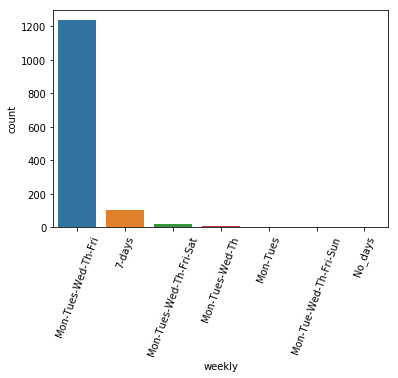

In [9]:
# Number of buildings in each weekly group
sns.countplot(x="weekly", data=meta, )
plt.xticks(rotation=70)

Looking at the last table, we get some more insights on power utilization. We can observe a higher number
buildings (e.g., 1236) having the power turned on. Now, it would be interesting to look if these patterns correlate with the spikes observed in the timeseries. If so, we can think of creating 7 different models, each locked to a specific power usage.  

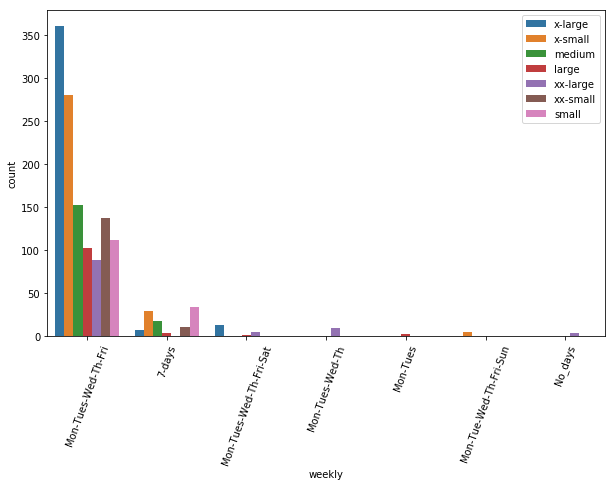

In [10]:
# Number of buildings for each weekly group deparated by their surface
plt.figure(figsize=(10,6))
sns.countplot(x="weekly", data=meta, hue="surface")
plt.xticks(rotation=70)
plt.legend(loc = 'upper right')

In [11]:
energy.head()

,series_id,timestamp,consumption,temperature
0,103088,2014-12-24 00:00:00,101842.233424,NaN
1,103088,2014-12-24 01:00:00,105878.048906,NaN
2,103088,2014-12-24 02:00:00,91619.105008,NaN
3,103088,2014-12-24 03:00:00,94473.706203,NaN
4,103088,2014-12-24 04:00:00,96976.755526,NaN


In [12]:
meta.head()

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,weekly
0,100003,x-large,low,False,False,False,False,False,True,True,Mon-Tues-Wed-Th-Fri
1,100004,x-large,low,False,False,False,False,False,True,True,Mon-Tues-Wed-Th-Fri
2,100006,x-small,low,False,False,False,False,False,True,True,Mon-Tues-Wed-Th-Fri
3,100008,x-small,low,False,False,False,False,False,True,True,Mon-Tues-Wed-Th-Fri
4,100010,x-small,low,False,False,False,False,False,True,True,Mon-Tues-Wed-Th-Fri


In [13]:
energy = pd.merge(energy, meta[["series_id", "surface", "base_temperature", "weekly"]], on="series_id")
energy.head()

,series_id,timestamp,consumption,temperature,surface,base_temperature,weekly
0,103088,2014-12-24 00:00:00,101842.233424,NaN,x-small,low,Mon-Tues-Wed-Th-Fri
1,103088,2014-12-24 01:00:00,105878.048906,NaN,x-small,low,Mon-Tues-Wed-Th-Fri
2,103088,2014-12-24 02:00:00,91619.105008,NaN,x-small,low,Mon-Tues-Wed-Th-Fri
3,103088,2014-12-24 03:00:00,94473.706203,NaN,x-small,low,Mon-Tues-Wed-Th-Fri
4,103088,2014-12-24 04:00:00,96976.755526,NaN,x-small,low,Mon-Tues-Wed-Th-Fri


## Plotting the relationship between the energy consumption and the size of the building

In the following section, I'll be looking at the relationship between the surface, the weekly use, and the electricity consumption. First, we will look at:
    - the relationship between consumption and the size of the building (i.e., surface)
    - the relationship between the consumption and the ON/OFF time during the week
    - the relationship between the consumption and the ON/OFF time grouped by the surface

### Consumption and surface

In [14]:
# Plotting the relationship between the energy consumption and the size of the building

order = ["xx-small", "x-small", "small", "medium", "large", "x-large", "xx-large"]

def plot_boxplot_barplot(x, y, data, order, ci, hue):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    sns.boxplot(x=x, y=y, data=data, order=order)
    plt.xticks(rotation=70)
    
    plt.subplot(1,2,2)
    sns.barplot(x=x, y=y, ci=ci, data=data, order=order, hue=hue)
    plt.xticks(rotation=70)

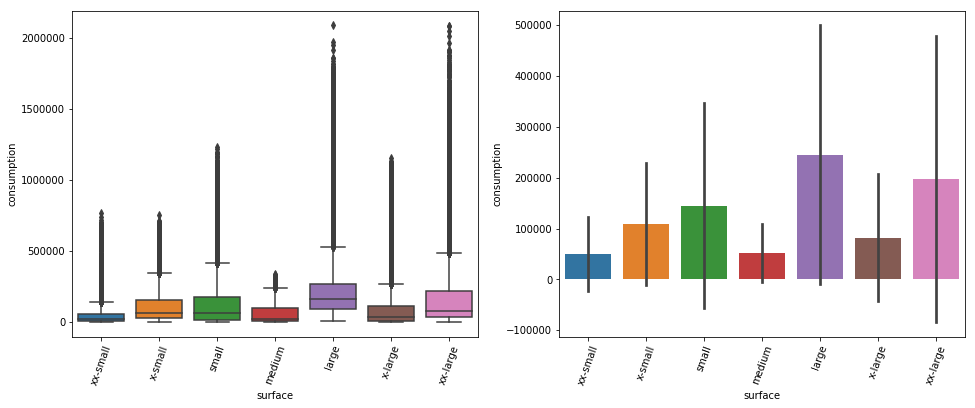

In [15]:
plot_boxplot_barplot("surface", "consumption", data=energy, order=order, ci="sd", hue=None)

### Consumption versus ON/OFF time 

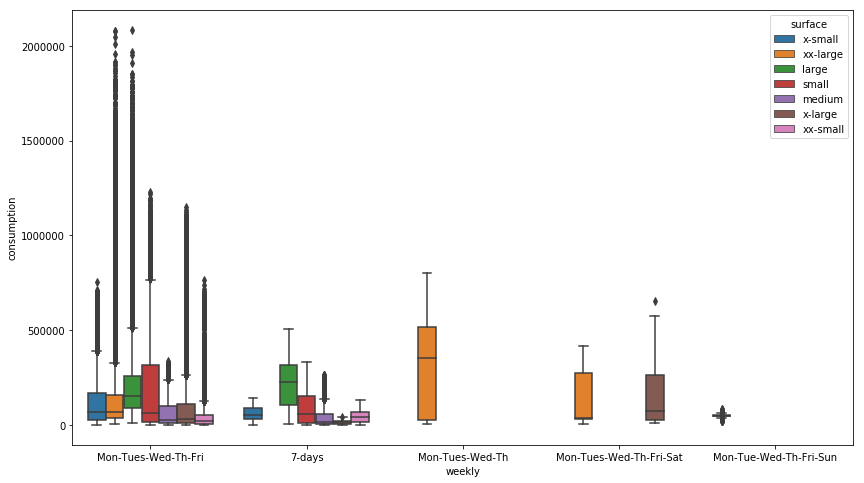

In [18]:
plt.figure(figsize=(14,8))
sns.boxplot(x="weekly", y="consumption", data=energy, hue="surface")

### Consumption versus ON/OFF time grouped by building size

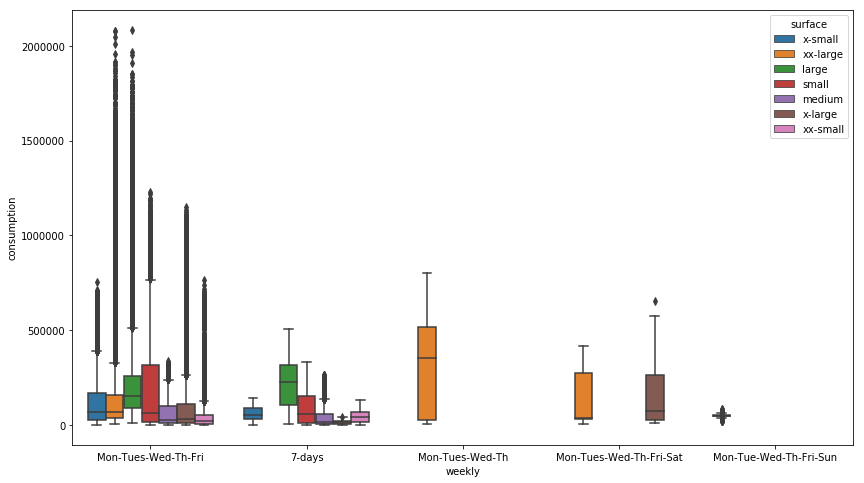

In [17]:
plt.figure(figsize=(14,8))
sns.boxplot(x="weekly", y="consumption", data=energy, hue="surface")

From the previous EDA, we can say that:
- large buildings have a greater energy consumption in average. 
- XX-large buildings with energy consumption on Mon/Tue/Wed/Th have the highest energy consumption.
- a large amount of variation is probably explained by the ON/OFF pattern and the number of buildings associated with this pattern

## Consumption Distributions

In [19]:
def plot_distplot(x, y, data, order, ci, hue):  
    plt.figure(figsize=(16,18))
    building_type_list = data[x].unique()
    num_building_type = len(building_type_list)    
    for i in range(num_building_type):
        plt.subplot(round((num_building_type+1)/2),2,i+1)
        sns.distplot(data[data[x]==building_type_list[i]][y], axlabel = building_type_list[i])

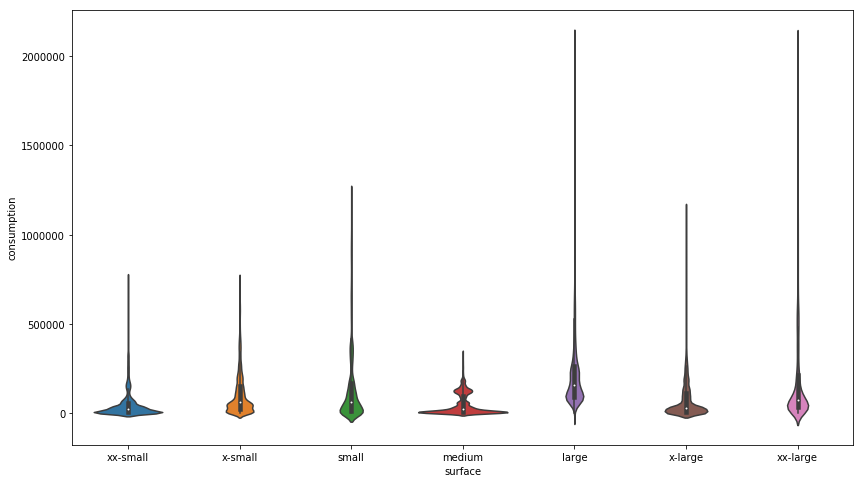

In [20]:
plt.figure(figsize=(14,8))
sns.violinplot("surface", "consumption", data=energy, order=order)

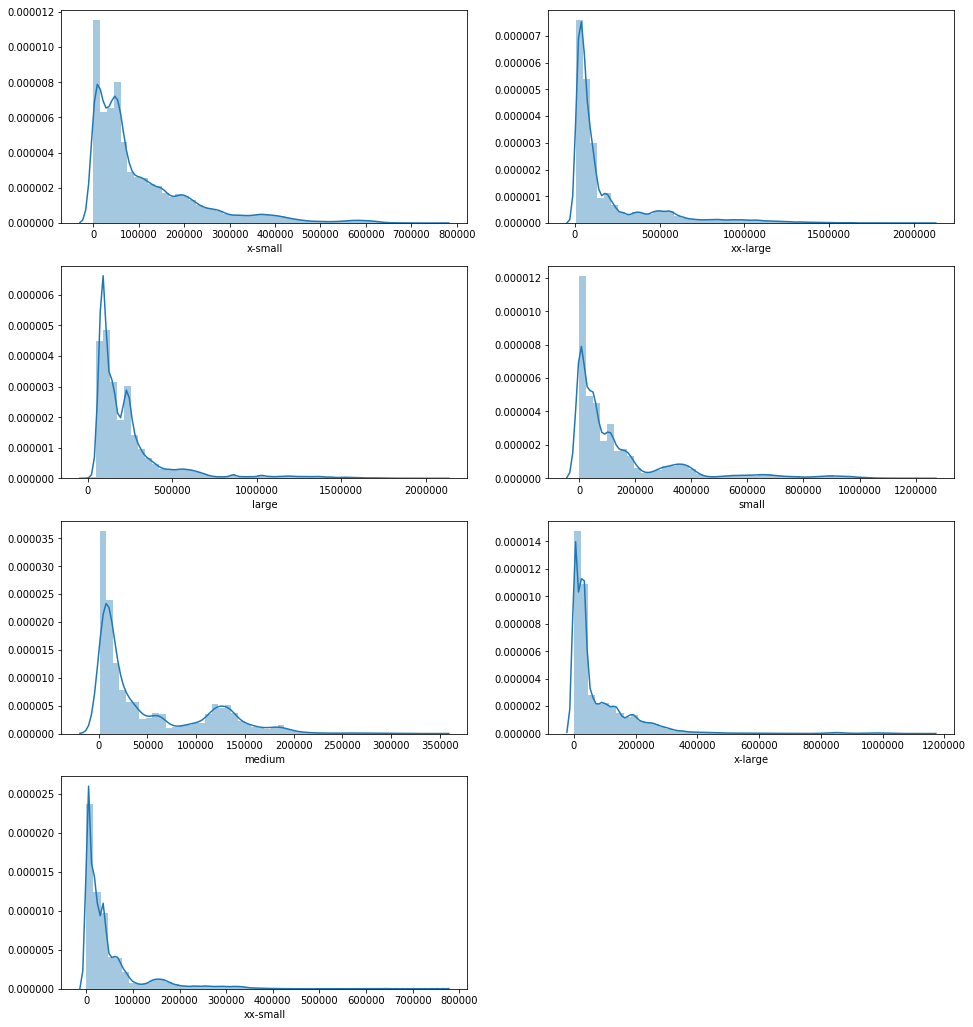

In [21]:
plot_distplot("surface", "consumption", data=energy, order=order, ci="sd", hue=None)

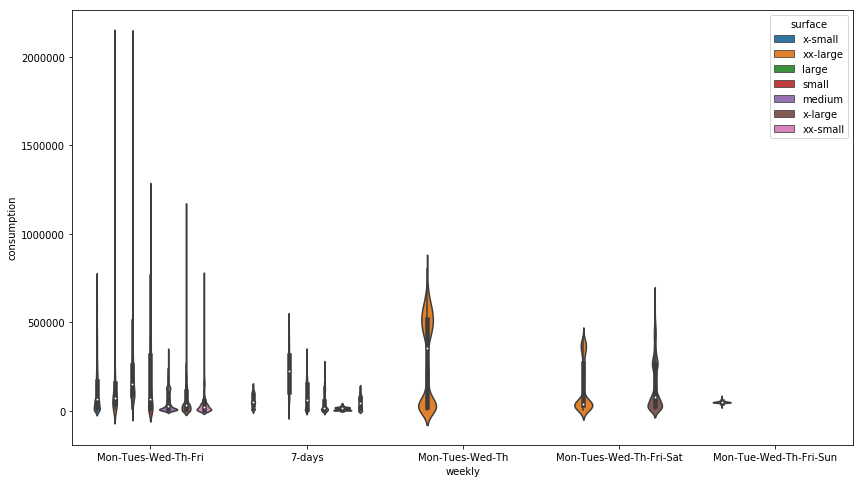

In [22]:
plt.figure(figsize=(14,8))
sns.violinplot(x="weekly", y="consumption", data=energy, order=None, ci=None, hue="surface")

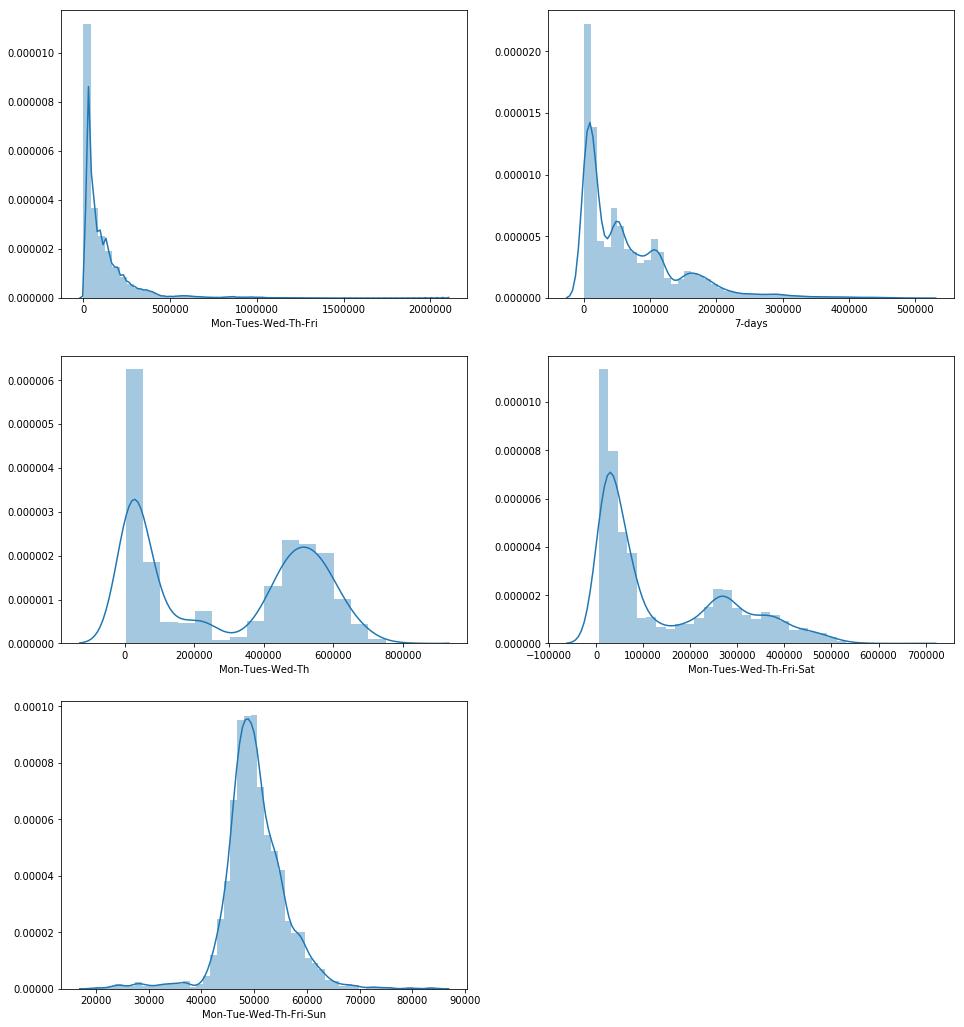

In [23]:
plot_distplot(x="weekly", y="consumption", data=energy, order=None, ci=None, hue="surface")

## Time Series Pattern According To The ON/OFF State

Below is an overview of the energy consumption for 5 xx-large buildings with energy on the ON-state Mon/Tues/Wed/Th/Sat. We can see a clear pattern related to the ON/OFF state which suggest that buildings with different patterns may have a different tiie series model created specifically for them.

In [24]:
# Subsetting a dataframe with the Mon/Tues/Wed/Th/Sat state
df1 = energy[(energy.weekly == "Mon-Tues-Wed-Th-Fri-Sat")][energy.surface == "xx-large"]
print(df1.shape)
df1.series_id.unique()


(3360, 7)


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


array([100979, 103457, 101443, 101792, 103373])

(array([-36., -24., -12.,   0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,
         96., 108., 120., 132., 144., 156., 168., 180., 192., 204., 216.,
        228., 240., 252., 264., 276., 288., 300., 312., 324., 336., 348.,
        360., 372., 384., 396., 408., 420., 432., 444., 456., 468., 480.,
        492., 504., 516., 528., 540., 552., 564., 576., 588., 600., 612.,
        624., 636., 648., 660., 672., 684., 696., 708.]),
 <a list of 63 Text xticklabel objects>)

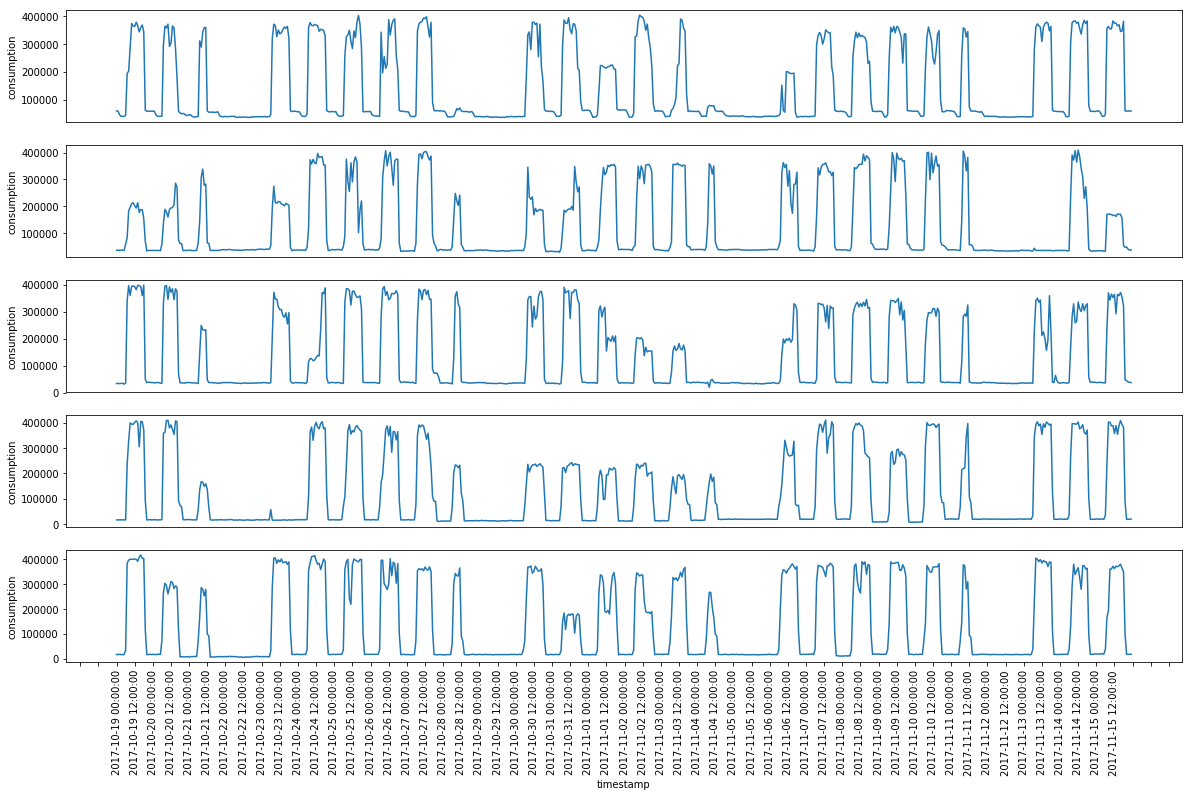

In [25]:
import matplotlib.ticker as ticker
    
plt.figure(figsize=(20,12))
    
plt.subplot(5,1,1)
ax = sns.lineplot(x="timestamp", y="consumption", data=df1[df1.series_id==100979])
ax.set_xlabel('')
ax.set(xticks=[])

plt.subplot(5,1,2)
bx = sns.lineplot(x="timestamp", y="consumption", data=df1[df1.series_id==103457])
bx.set_xlabel('')
bx.set(xticks=[])

plt.subplot(5,1,3)
cx = sns.lineplot(x="timestamp", y="consumption", data=df1[df1.series_id==101443])
cx.set_xlabel('')
cx.set(xticks=[])

plt.subplot(5,1,4)
dx = sns.lineplot(x="timestamp", y="consumption", data=df1[df1.series_id==101792])
dx.set_xlabel('')
dx.set(xticks=[])

plt.subplot(5,1,5)
ex=sns.lineplot(x="timestamp", y="consumption", data=df1[df1.series_id==103373])
ex.xaxis.set_major_locator(ticker.MultipleLocator(12))
plt.xticks(rotation=90)

In [26]:
# Taking 5 timeseries with an "xx-large" surface and a weekly pattern of "Mon-Tues-Wed-Th-Fri-Sat"
subj = [100979, 103457, 101443, 101792, 103373]

# Function to generate five df in which a column with standardized score for consumption
# is added and the index is reset so we could plot them from the same start point (regardless of the start date)
def prepare_data(data, subject, count_col, new_col):
    df = data[data.series_id == subject]
    df = df.reset_index()
    df[count_col] = df.index
    df[new_col] = (df["consumption"] - df["consumption"].mean())/ df["consumption"].std()
    return df

dic = {}
for i in subj:
    dic[i] = prepare_data(df1, i, "count", "consumption_std")
    
frames = [dic[100979],dic[101443], dic[101792], dic[103373], dic[103457]]
result = pd.concat(frames)


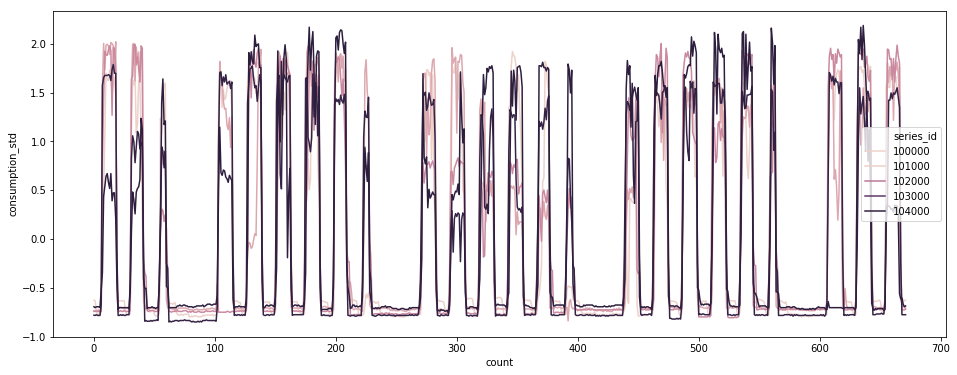

In [27]:
# Plotting the five ts on the same line plot to appreciate the similarities/differences
plt.figure(figsize=(16,6))
result["series_id"] = result["series_id"]
sns.lineplot(x="count", y="consumption_std", hue="series_id", data=result)

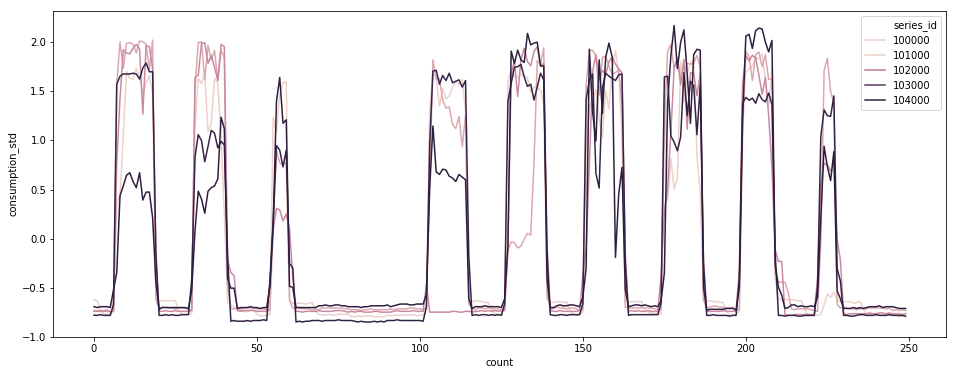

In [28]:
# Zoom in of the previous figure on the first 250 data points
count_result = result[result["count"] < 250]
plt.figure(figsize=(16,6))
result["series_id"] = result["series_id"]
sns.lineplot(x="count", y="consumption_std", hue="series_id", data=count_result)

In [33]:
import random
weekly_cat = meta["weekly"].unique()

def plot_random_series(surface_type, weekly_type, num_series_to_plot = 1):
    # Subsetting a dataframe 
    df_subset = energy[(energy.weekly == weekly_type)][energy.surface == surface_type]
    plt.figure(figsize=(20,15))
    title_str = "Building Type [" + surface_type + "] [" + weekly_type + "]"
    for k in range(1, num_series_to_plot+1):
        series_list = df_subset.series_id.unique()
        if (len(series_list) > 0):
            rand_series_id = random.choice(series_list)
            plt.subplot(num_series_to_plot,1,k)
            ax = sns.lineplot(x="timestamp", y="consumption", data=df_subset[df_subset.series_id==rand_series_id])
            ax.set_title(title_str+ " " + "Series: " + str(rand_series_id))
            ax.set_xlabel('')
            ax.set(xticks=[])
            ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
            plt.subplots_adjust(hspace = .5)
          

In [35]:
plot_random_series(surface_type= 'small', weekly_type = '1111111', num_series_to_plot = 5)

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 1440x1080 with 0 Axes>

In [31]:
def plot_acf_random_series(surface_type, weekly_type, num_series_to_plot = 1):
    # Subsetting a dataframe 
    df_subset = energy[(energy.weekly == weekly_type)][energy.surface == surface_type]
    title_str = "Building Type [" + surface_type + "] [" + weekly_type + "]"
    for k in range(1, num_series_to_plot+1):
        series_list = df_subset.series_id.unique()
        if (len(series_list) > 0):
            fig = plt.figure(figsize=(8,3))
            fig.suptitle(title_str)
            rand_series_id = random.choice(series_list)
            pd.plotting.autocorrelation_plot(df_subset[df_subset.series_id==rand_series_id]["consumption"])

In [32]:
plot_acf_random_series(surface_type= 'small', weekly_type = '1111111', num_series_to_plot = 5)

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [ ]:
# Save the meta and energy df to pickle
interim_data_directory = "..\\data\\interim\\"
meta.to_pickle(interim_data_directory + 'meta_df.pkl')
energy.to_pickle(interim_data_directory + 'energy_df.pkl')

In [ ]:
!dir $interim_data_directory